In [1]:
import os
os.chdir('/Users/jjaniak/Documents/studia/projekt/gradient')

import geopandas as gpd
import pandas as pd
import json

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import shap
import numpy as np

from shapely.wkt import loads

from esda.moran import Moran_Local
import libpysal

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from src.embedders.osm_data_embedder import OSMDataEmbedder
from srai.regionalizers import geocode_to_region_gdf
from srai.embedders import CountEmbedder
from srai.regionalizers import H3Regionalizer
from srai.loaders.osm_loaders.filters import OsmTagsFilter

from IPython.display import display

pd.set_option("display.max_columns", None)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


json_folder_path = "notebooks/accident_analysis/out/data_analysis_results/"

/Users/jjaniak/Documents/studia/projekt/gradient/.conda/lib/python3.8/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.2-CAPI-1.17.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/var/folders/4k/8js3jm9n457cm4_v631zyrkw0000gn/T/ipykernel_45614/2177072690.py:4: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get sp

In [2]:
city_name = "Pozna\u0144"
nominatim_city_name = "Pozna\u0144, Poland"
year = 2022

In [3]:
# Parameters
city_name = "Pozna\u0144"
nominatim_city_name = "Pozna\u0144, Poland"
year = 2022


## Functions

In [31]:
query: OsmTagsFilter = {"highway": True, "railway": True, "route": True, "amenity": True}

def rename_columns_for_saving(hex_and_features_gdf):
    # Define a mapping for renaming columns
    column_mapping = {
        "highway": "H_",
        "railway": "R_",
        "amenity": "A_",
        "route": "RO_",
    }

    # Rename columns based on the defined mapping
    for prefix, replacement in column_mapping.items():
        columns_to_rename = [col for col in hex_and_features_gdf.columns if col.startswith(prefix + "_")]
        new_column_names = [replacement + col[len(prefix) + 1:] for col in columns_to_rename]
        hex_and_features_gdf.rename(columns=dict(zip(columns_to_rename, new_column_names)), inplace=True)

    return hex_and_features_gdf

def create_hex_gds(h3_resolution, city_name=city_name):
    data_embedder = OSMDataEmbedder(
        area=geocode_to_region_gdf(nominatim_city_name),
        embedder=CountEmbedder(),
        regionalizer=H3Regionalizer(resolution=h3_resolution),
        query=query,
    )
    filename = f"data/baseline-datasets/in/{city_name}-hex-res-{h3_resolution}-and-features_with_amenity-gdf_fixed_names.shp"
    if not os.path.exists(filename):
        hex_and_features_gdf = data_embedder.make_embeddings()  # type: ignore
        hex_and_features_gdf_fixed_names = rename_columns_for_saving(hex_and_features_gdf)
        hex_and_features_gdf_fixed_names.to_file(
            filename,
            index=True,
        )
    else:
        hex_and_features_gdf = gpd.read_file(filename)
        hex_and_features_gdf.set_index("region_id", inplace=True)

    return hex_and_features_gdf


def get_accidents_gdf(h3_resolution, city_name=city_name, year=year):
    filename = f"data/accidents_in_hex/{city_name}_accidents_{year}_res{h3_resolution}.csv"
    if not os.path.exists(filename):
        raise FileNotFoundError(f"The file {filename} does not exist.")
    else:
        accidents_df = pd.read_csv(filename)
        accidents_df['geometry'] = accidents_df['geometry'].apply(loads)
        accidents_gdf = gpd.GeoDataFrame(accidents_df, geometry='geometry', crs="EPSG:4326")
        return accidents_gdf
    
def merge_gdf(resolution):
    filename = f"data/accidents_in_hex/{city_name}_accidents_and_features_{year}_res{resolution}.shp"
    if not os.path.exists(filename):
        hex_and_features_gdf = create_hex_gds(h3_resolution=resolution, city_name=city_name)
        accidents_gdf = get_accidents_gdf(h3_resolution=resolution, city_name=city_name, year=year)
        merged_gdf = gpd.sjoin(left_df=accidents_gdf, right_df=hex_and_features_gdf, how='inner', op='intersects')
        merged_gdf = merged_gdf.drop(columns='index_right')
        merged_gdf['num_accidents'] = merged_gdf['count'].astype(int)
        merged_gdf.drop(columns=['count'], inplace=True)
        merged_gdf['binary_accidents'] = 0  # Initialize with 0
        merged_gdf.loc[merged_gdf["num_accidents"] > 0, "binary_accidents"] = 1.0
        merged_gdf.to_file(
            filename,
            index=True,
        )
    else:
        merged_gdf = gpd.read_file(filename)
        merged_gdf.set_index("region_id", inplace=True)
    
    merged_gdf.rename(columns={'num_accide': 'num_accidents', 'binary_acc': 'binary_accidents'}, inplace=True)
    return merged_gdf

In [5]:
def local_moran(df, column):
    w = libpysal.weights.Queen.from_dataframe(df)
    y = df[column].values
    moran_loc = Moran_Local(y, w)
    return moran_loc.Is, moran_loc.p_sim, moran_loc.q

In [6]:
from enum import Enum


class FeatureGoups(Enum):
    HIGHWAY = "H"
    RAILWAY = "R"
    AMENITY = "A"
    ROUTE  = "RO"
    

def analyze_features(merged_gdf:pd.DataFrame, feature_group: FeatureGoups):
    
    # Filter columns starting with feature group name
    feature_group_columns = merged_gdf.columns[merged_gdf.columns.str.startswith(feature_group.value)]

    # Sum values
    sum_feature_values = merged_gdf[feature_group_columns].sum()
    
    if sum_feature_values.size == 1:
        print(f"Found only one feature for feature group {feature_group.name}")
        display(sum_feature_values)
        return []
        
    else:
        plt.figure(figsize=(10, 6))
        sns.histplot(sum_feature_values, bins=50, kde=True, color='skyblue', edgecolor='black')
        plt.title(f'Histogram of {feature_group.name} Features')
        plt.xlabel('Sum')
        plt.ylabel('Frequency')
        plt.show()

        quartiles = sum_feature_values.quantile([0.25, 0.5, 0.75])

        iqr = quartiles[0.75] - quartiles[0.25]
        lower_bound = quartiles[0.25] - 1.5 * iqr
        upper_bound = quartiles[0.75] + 1.5 * iqr

        most_common_features = list(sum_feature_values[(sum_feature_values > upper_bound)].index)
        least_common_features = list(sum_feature_values[(sum_feature_values < lower_bound)].index)
        display(sum_feature_values.describe())
        print(f"\nMost common features for {feature_group.name}: \n {most_common_features}")
        if least_common_features:
            print(f"\nLeast common features for {feature_group.name}: \n {least_common_features}")
        
        return most_common_features
    
    
def analyze_imbalance(merged_gdf, feature_group):
    feature_group_columns = list(merged_gdf.columns[merged_gdf.columns.str.startswith(feature_group.value)]) + ['binary_accidents']
    grouped_data = merged_gdf[feature_group_columns].groupby('binary_accidents').sum()
    percentage_data = grouped_data.div(grouped_data.sum(axis=0))
        
    imbalance_ratio = abs(grouped_data.diff(axis=0) / grouped_data.sum(axis=0)).round(2)
    imbalance_ratio = imbalance_ratio.loc[1]
    
    print(f"\nMetrics of Imbalance in {feature_group.name}")
    if imbalance_ratio.size > 1:
        display(imbalance_ratio.T.describe())
    else:
        display(imbalance_ratio)
    
    high_imbalance_features = imbalance_ratio[imbalance_ratio >= 0.5]
    if high_imbalance_features.size > 0:
        print(f"\nThere are {len(high_imbalance_features)} high imbalance features in {feature_group.name}")
        for feature in high_imbalance_features.index:
            print(feature)
        display(percentage_data[high_imbalance_features.index])

        return high_imbalance_features.index
    else:
        return []

In [7]:
def correlation_analysis(merged_gdf, resolution):
    
    all_features = merged_gdf.drop(columns=['geometry', 'region_id', 'num_accidents', 'binary_accidents']).columns.to_list()
    
    correlation_matrix = merged_gdf[all_features + ['binary_accidents']].corr()
    correlation_values = correlation_matrix['binary_accidents']

    correlation_metrics = correlation_values.drop('binary_accidents').describe()

    # Filter features based on IQR 
    high_corr_features = correlation_values[(correlation_values >= 0.2) | (correlation_values <= -0.2)].index.to_list()
    low_corr_features = correlation_values[(correlation_values < 0.2) & (correlation_values > -0.2)].index.to_list()

    high_corr_features.remove('binary_accidents')
    correlation_matrix_best_features = merged_gdf[high_corr_features + ['binary_accidents']].corr()

    if high_corr_features != []:
        plt.figure(figsize=(14, 12))
        sns.heatmap(correlation_matrix_best_features, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={'size': 6})
        plt.title(f'Correlation Heatmap (best features) for resolution = {resolution}')
        plt.show()

    return high_corr_features, low_corr_features, correlation_metrics

In [8]:
def shap_analysis(h3_resolution, merged_gdf, selected_features, city_name=city_name, save_force_plot=False):
    print(f"Analysis for Resolution = {h3_resolution}")
    
    y = merged_gdf['binary_accidents']
    X = merged_gdf[selected_features]

    feature_names = X.columns.tolist()
    
    X_train, X_test, y_train, _ = train_test_split(X, y, test_size=0.3, random_state=42)
    
    scaler = preprocessing.StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=feature_names)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=feature_names)
    
    linear_lr = LogisticRegression(max_iter=1000)
    linear_lr.fit(X_train_scaled, y_train)

    #Przygotowanie przybliżonej próbki tła za pomocą metody k-means.
    background_summary = shap.kmeans(X_train, 10)

    explainer = shap.KernelExplainer(linear_lr.predict_proba, background_summary)

    #Obliczenie SHAP wartości dla danych testowych (X_test), co pozwala na zrozumienie, jak każda zmienna przyczynia się do przewidywanej wartości.
    shap_values = explainer.shap_values(X_test_scaled)

    shap.summary_plot(shap_values, X_test_scaled)

    if save_force_plot:
        shap.initjs()
        p = shap.force_plot(explainer.expected_value[0], shap_values[0], X_test_scaled)
        shap.save_html(json_folder_path + f'{city_name}_res_{h3_resolution}_force_plot_best_features.html', p)

## Analysis

In [32]:
# Set resolutions
resolutions = [8, 9, 10]

# Initialize dataframe and dictionaries to store results
distribution_results = pd.DataFrame(columns=['Resolution', 'Num_Hexes', 'Accidents_Mean', 'Accidents_Std','Binary_Accidents_Mean', 'Binary_Accidents_Std'])

local_moran_results = {} 
highest_imbalance_features_dict = {}


# Loop through resolutions
for resolution in resolutions:
    
    print(f"Analysis for Resolution = {resolution}")
    
    # Create hex dataframes
    merged_gdf = merge_gdf(resolution)
    
    # Accidents Distribution
    new_row = {
        'Resolution': resolution,
        'Num_Hexes': len(merged_gdf),
        'Accidents_Mean': merged_gdf['num_accidents'].mean(),
        'Accidents_Std': merged_gdf['num_accidents'].std(),
        'Binary_Accidents_Mean': merged_gdf['binary_accidents'].mean(),
        'Binary_Accidents_Std': merged_gdf['binary_accidents'].std()
    }
    result_df = pd.DataFrame([new_row], columns=distribution_results.columns)
    distribution_results = pd.concat([distribution_results, result_df], ignore_index=True)

    # Calculate Local Moran's I
    moran_i, p_sim, q = local_moran(merged_gdf, column='num_accidents')
    local_moran_results[resolution] = {'moran_i': moran_i, 'p_sim': p_sim, 'q': q}

Analysis for Resolution = 8


`use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning


Analysis for Resolution = 9


`use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning


Analysis for Resolution = 10


`use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning


### Rozkład wypadków

In [10]:
print("Distribution of Accidents in Hexes:")
display(distribution_results) 

Distribution of Accidents in Hexes:


,Resolution,Num_Hexes,Accidents_Mean,Accidents_Std,Binary_Accidents_Mean,Binary_Accidents_Std
0,8,3073,1.253824,2.359186,0.395054,0.488942
1,9,19917,0.194055,0.652716,0.118241,0.322901
2,10,136151,0.028373,0.209566,0.022872,0.149495


#### Wnioski
- Na niższych rozdzielczościach heksagony mają tendencję do grupowania większej liczby wypadków.
- Odchylenie standardowe liczby wypadków maleje wraz ze wzrostem rozdzielczości. 
- Odchylenie standardowe na skali binarnej jest największe dla rozdzielczości 8 (0.49), co sugeruje większe zróżnicowanie między heksagonami pod względem obecności lub braku wypadków.


### Correlation

Analysis for Resolution = 8


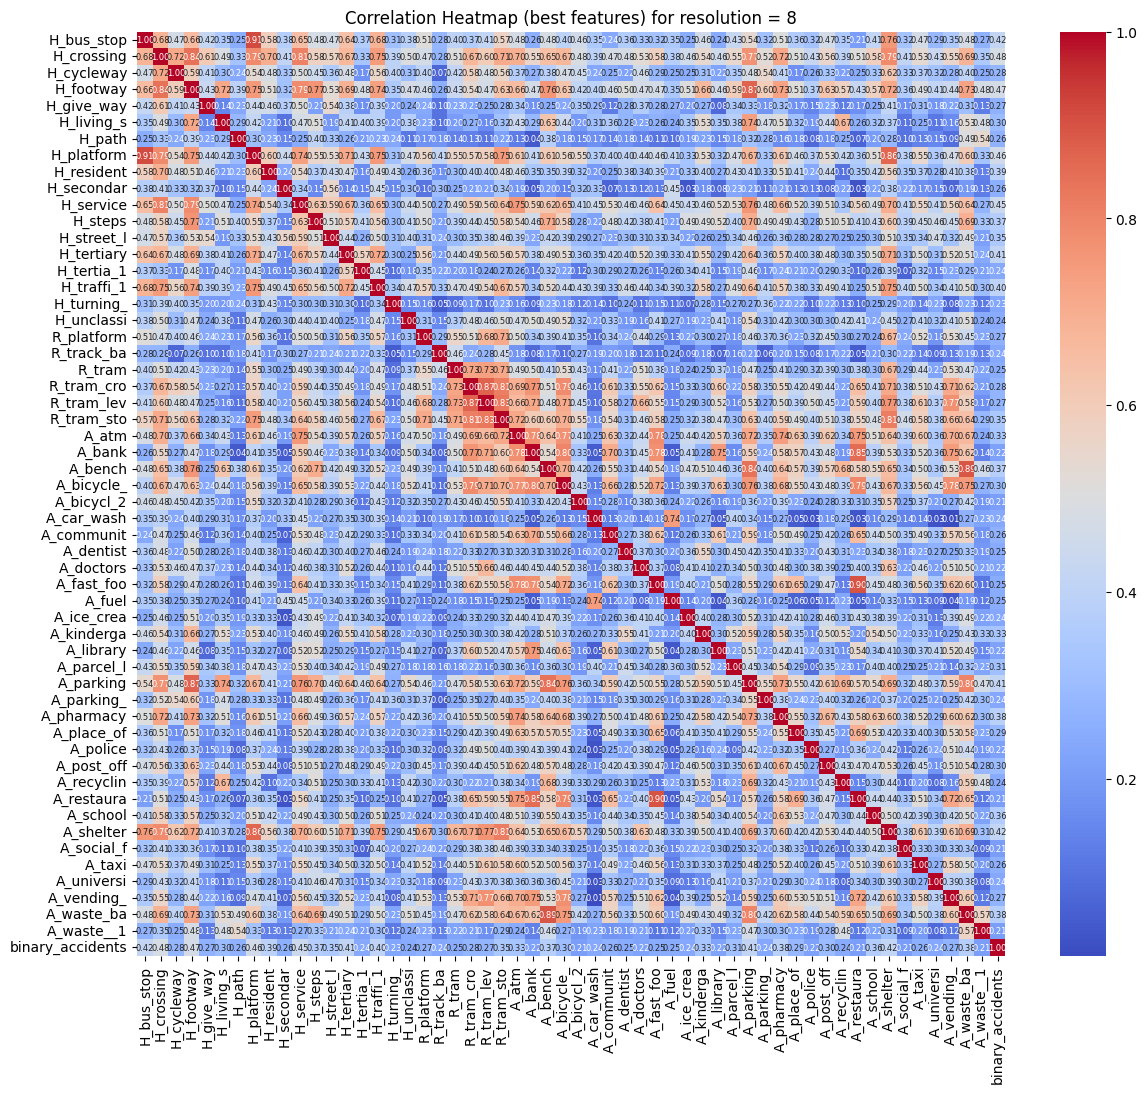

Analysis for Resolution = 9


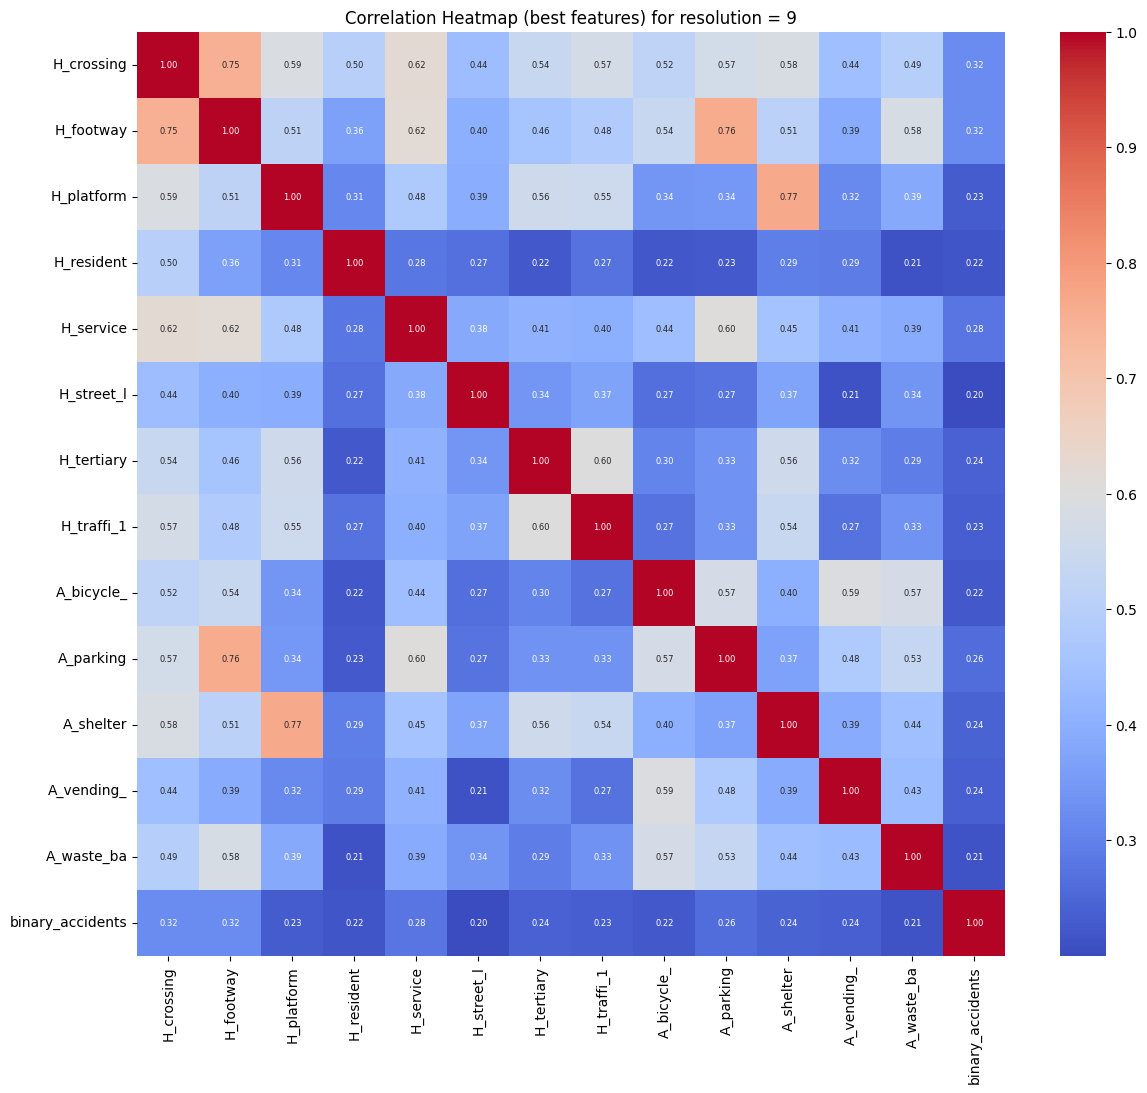

Analysis for Resolution = 10


In [33]:
df_correlation_metrics = pd.DataFrame()

all_high_corr_features = {}
all_low_corr_features = {}

# Loop through resolutions
for resolution in resolutions:
    print(f"Analysis for Resolution = {resolution}")
    merged_gdf = merge_gdf(resolution)
    merged_gdf.reset_index(inplace=True)
    highest_corr_features, low_corr_features, correlation_metrics = correlation_analysis(merged_gdf, resolution)
    all_low_corr_features[resolution] = low_corr_features
    all_high_corr_features[resolution] = highest_corr_features
    df_correlation_metrics = pd.concat([df_correlation_metrics, correlation_metrics], axis=1)


file_path = json_folder_path + f'all_high_corr_features_{city_name}.json'
with open(file_path, 'w') as json_file:
    json.dump(all_high_corr_features, json_file)
    
file_path = json_folder_path + f'all_low_corr_features_{city_name}.json'
with open(file_path, 'w') as json_file:
    json.dump(all_low_corr_features, json_file)

In [34]:
df_correlation_metrics.columns = [f'resolution={resolution}' for resolution in resolutions]
print("Correlation Metrics of Binary Accidents with All Features:")
display(df_correlation_metrics)

Correlation Metrics of Binary Accidents with All Features:


,resolution=8,resolution=9,resolution=10
count,216.000000,216.000000,216.000000
mean,0.129780,0.060756,0.022228
std,0.120731,0.070237,0.032845
min,-0.077536,-0.038951,-0.027882
25%,0.044918,0.010786,-0.001097
50%,0.095099,0.038016,0.009805
75%,0.207846,0.092509,0.029414
max,0.478786,0.321900,0.161044


In [35]:
file_path = json_folder_path + f'all_high_corr_features_{city_name}.json'
with open(file_path, 'r') as json_file:
    all_high_corr_features = json.load(json_file)
    
print("Best Features Based on Correlation:\n")
for resolution, best_features in all_high_corr_features.items():
    print(f"\nResolution {resolution}:")
    for feature in best_features:
        print(f"{feature}")

Best Features Based on Correlation:


Resolution 8:
H_bus_stop
H_crossing
H_cycleway
H_footway
H_give_way
H_living_s
H_path
H_platform
H_resident
H_secondar
H_service
H_steps
H_street_l
H_tertiary
H_tertia_1
H_traffi_1
H_turning_
H_unclassi
R_platform
R_track_ba
R_tram
R_tram_cro
R_tram_lev
R_tram_sto
A_atm
A_bank
A_bench
A_bicycle_
A_bicycl_2
A_car_wash
A_communit
A_dentist
A_doctors
A_fast_foo
A_fuel
A_ice_crea
A_kinderga
A_library
A_parcel_l
A_parking
A_parking_
A_pharmacy
A_place_of
A_police
A_post_off
A_recyclin
A_restaura
A_school
A_shelter
A_social_f
A_taxi
A_universi
A_vending_
A_waste_ba
A_waste__1

Resolution 9:
H_crossing
H_footway
H_platform
H_resident
H_service
H_street_l
H_tertiary
H_traffi_1
A_bicycle_
A_parking
A_shelter
A_vending_
A_waste_ba

Resolution 10:


In [36]:
common_features = set(all_high_corr_features['8']) & set(all_high_corr_features['9']) & set(all_high_corr_features['10'])
if common_features != []:
    print("Common Features With High Correlation Across All Resolutions:")
    for feature in common_features:
        print(feature)
    
common_features = set(all_high_corr_features['8']) & set(all_high_corr_features['9'])
if common_features != []:
    print("Common Features With High Correlation Across Resolutions 8 and 9:")
    for feature in common_features:
        print(feature)

Common Features With High Correlation Across All Resolutions:
Common Features With High Correlation Across Resolutions 8 and 9:
H_service
H_tertiary
H_footway
H_resident
A_shelter
A_waste_ba
H_street_l
A_parking
H_platform
H_crossing
A_bicycle_
H_traffi_1
A_vending_


In [37]:
file_path = json_folder_path + f'all_low_corr_features_{city_name}.json'
with open(file_path, 'r') as json_file:
    all_low_corr_features = json.load(json_file)


common_features = set(all_low_corr_features['8']) & set(all_low_corr_features['9']) & set(all_low_corr_features['10'])
if common_features != []:
    print("Common Features With Low Correlation Across All Resolutions:")
    for feature in common_features:
        print(feature)

Common Features With Low Correlation Across All Resolutions:
A_compress
A_events_v
A_bar
R_loadin_1
A_biergart
A_training
A_car_rent
A_monaster
H_corridor
A_toilets
R_track_sc
R_signal_b
R_railway_
R_disused
A_fire_sta
H_primary
A_cremator
A_courthou
H_trunk
R_junction
A_vehicl_1
A_bicycl_1
H_second_1
A_give_box
A_pub
A_planter
A_charging
A_bbq
A_paymen_1
A_trolley_
R_rail_bra
H_elevator
A_driving_
A_nightclu
H_passing_
H_services
H_track
A_flight_s
A_loading_
A_financia
A_water_po
H_traffic_
A_bo
A_clinic
R_loading_
A_drinking
A_mist_spr
A_conferen
A_baby_hat
A_veterina
H_speed_ca
A_food_cou
A_security
R_signal
H_mileston
A_dancing_
A_vehicle_
R_site
A_cinema
A_passenge
A_outdoor_
A_casino
H_construc
A_spa
A_langua_1
R_turntabl
R_crossi_1
H_raceway
A_luggage_
A_fountain
A_library_
R_derail
R_level_tr
A_college
A_theatre
A_tools_re
R_station
H_bridlewa
H_pedestri
A_arts_cen
A_studio
H_give_w_1
A_grave_ya
A_music_sc
A_boat_ren
A_traffic_
A_weighbri
A_vacuum_c
R_demolish
A_cafe
A_parkin_

### Istotne cechy

In [18]:
file_path = json_folder_path + f'all_high_corr_features_{city_name}.json'
with open(file_path, 'r') as json_file:
    all_high_corr_features = json.load(json_file)
    
# Loop through resolutions
for resolution in resolutions:
    print(f"Analysis for Resolution = {resolution}")
    merged_gdf = merge_gdf(resolution)
    merged_gdf.reset_index(inplace=True)
    highest_corr_features = all_high_corr_features[str(resolution)]
    
    # Summary statistics of numerical columns
    summary_statistics = merged_gdf.describe()

    all_high_imbalance_features = []
    
    feature_groups = [FeatureGoups.AMENITY, FeatureGoups.HIGHWAY, FeatureGoups.RAILWAY, FeatureGoups.ROUTE]
    for feature_group in feature_groups:
        feature_group_columns = list(merged_gdf.columns[merged_gdf.columns.str.startswith(feature_group.value)])
        mean_row = summary_statistics[feature_group_columns].loc['mean']
        sorted_columns = mean_row.sort_values().index
        summary_statistics_sorted = summary_statistics[sorted_columns]
        print(f"\nSummary Statistics of Numerical Columns (Sorted by Mean) for {feature_group.name}:")
        display(summary_statistics_sorted)
        all_high_imbalance_features.extend(analyze_imbalance(merged_gdf, feature_group))
        highest_imbalance_features_dict[resolution] = all_high_imbalance_features
        

    filtered_columns = summary_statistics.columns[summary_statistics.loc['mean'] > 1]
    common_features_mean_more_than_1 = set(filtered_columns) & set(highest_corr_features)
    if common_features_mean_more_than_1:
        print(f"\nCommon features with mean in hex more than 1 and high correlation:")
        print(common_features_mean_more_than_1)
    else:
        print(f"\nThere is no common features with mean in hex more than 1 and high correlation.")
        
    filtered_columns = summary_statistics.columns[summary_statistics.loc['mean'] < 0.01]
    common_features_mean_less_than_001 = set(filtered_columns) & set(highest_corr_features)
    if common_features_mean_less_than_001:
        print(f"\nCommon features with mean in hex less than 0.01 and high correlation:")
        print(common_features_mean_less_than_001)
    else:
        print(f"\nThere is no common features with mean in hex less than 0.01 and high correlation.")
        
    common_features_highest_corr_and_imbalance = set(all_high_imbalance_features) & set(highest_corr_features)
    if common_features_highest_corr_and_imbalance:
        print(f"\nCommon features with high imbalance and high correlation:")
        print(common_features_highest_corr_and_imbalance)
    else:
        print(f"\nThere is no common features with high imbalance and high correlation.")
    

file_path = json_folder_path + f'highest_imbalance_features_dict_{city_name}.json'
with open(file_path, 'w') as json_file:
    json.dump(highest_imbalance_features_dict, json_file)

Analysis for Resolution = 8

Summary Statistics of Numerical Columns (Sorted by Mean) for AMENITY:


,A_outdoor_,A_payment_,A_flight_s,A_music_ve,A_motorcyc,A_mist_spr,A_lounge,A_lombard_,A_loading_,A_coworkin,A_cremator,A_dancing_,A_library_,A_doityour,A_letter_b,A_langua_1,A_internet,A_food_sha,A_casino,A_paymen_1,A_financia,A_sailing_,A_waste_di,A_ski_rent,A_boat_sto,A_baby_hat,A_bo,A_smoking_,A_social_c,A_spa,A_vehicl_1,A_vacant,A_water_po,A_training,A_animal_s,A_stables,A_luggage_,A_boat_ren,A_tools_re,A_music_sc,A_security,A_give_box,A_animal_t,A_events_v,A_stripclu,A_prison,A_grave_ya,A_weighbri,A_educatio,A_biergart,A_bicycl_1,A_dojo,A_dressing,A_ferry_te,A_passenge,A_public_b,A_townhall,A_grit_bin,A_food_cou,A_studio,A_courthou,A_drinking,A_hunting_,A_traffic_,A_conferen,A_driver_t,A_driving_,A_bus_stat,A_language,A_car_rent,A_cinema,A_vacuum_c,A_fire_sta,A_marketpl,A_college,A_research,A_arts_cen,A_bbq,A_childcar,A_compress,A_theatre,A_police,A_vehicle_,A_clock,A_nightclu,A_veterina,A_post_box,A_planter,A_bureau_d,A_communit,A_ice_crea,A_hospital,A_trolley_,A_charging,A_fountain,A_monaster,A_bicycl_2,A_bar,A_clinic,A_social_f,A_library,A_pub,A_taxi,A_post_off,A_fuel,A_dentist,A_lounger,A_car_wash,A_universi,A_bank,A_place_of,A_doctors,A_toilets,A_cafe,A_kinderga,A_fast_foo,A_pharmacy,A_school,A_atm,A_parcel_l,A_parking_,A_recyclin,A_restaura,A_vending_,A_shelter,A_waste__1,A_bicycle_,A_parkin_1,A_waste_ba,A_bench,A_parking
count,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000
mean,0.002278,0.002278,0.002278,0.002278,0.002278,0.002278,0.002278,0.002278,0.002278,0.002278,0.002278,0.002278,0.002278,0.002278,0.002278,0.002278,0.002278,0.002278,0.002278,0.002278,0.002278,0.002278,0.002278,0.002278,0.002278,0.002278,0.002278,0.002278,0.002278,0.002278,0.004556,0.004556,0.004556,0.004556,0.004556,0.004556,0.004556,0.004556,0.004556,0.006834,0.006834,0.006834,0.006834,0.006834,0.006834,0.008786,0.009112,0.009112,0.009112,0.009112,0.009112,0.009112,0.009112,0.013667,0.013667,0.013667,0.013667,0.015945,0.018223,0.020501,0.020501,0.020501,0.021477,0.022779,0.022779,0.022779,0.022779,0.027335,0.029613,0.029613,0.029613,0.034169,0.036121,0.038724,0.038724,0.041002,0.041002,0.043280,0.052066,0.054670,0.059226,0.061178,0.061503,0.063781,0.070615,0.072893,0.072893,0.079727,0.081679,0.086560,0.088838,0.091116,0.091767,0.103807,0.116173,0.123007,0.131793,0.134396,0.136674,0.137976,0.143508,0.148064,0.179954,0.195574,0.197201,0.197852,0.207289,0.218353,0.218679,0.298080,0.314676,0.373251,0.387569,0.409697,0.454605,0.497234,0.584120,0.652782


Metrics of Imbalance in AMENITY


count    131.000000
mean       0.633588
std        0.271727
min        0.000000
25%        0.445000
50%        0.640000
75%        0.865000
max        1.000000
Name: 1, dtype: float64


There are 93 high imbalance features in AMENITY
A_arts_cen
A_atm
A_baby_hat
A_bank
A_bar
A_bbq
A_bench
A_bicycle_
A_bicycl_1
A_biergart
A_bo
A_boat_sto
A_bureau_d
A_bus_stat
A_cafe
A_casino
A_childcar
A_cinema
A_clinic
A_clock
A_college
A_communit
A_conferen
A_courthou
A_coworkin
A_dentist
A_doctors
A_drinking
A_driver_t
A_driving_
A_educatio
A_fast_foo
A_ferry_te
A_financia
A_flight_s
A_food_cou
A_food_sha
A_fountain
A_give_box
A_grit_bin
A_hospital
A_hunting_
A_ice_crea
A_internet
A_kinderga
A_language
A_langua_1
A_library
A_library_
A_lombard_
A_luggage_
A_marketpl
A_mist_spr
A_monaster
A_motorcyc
A_music_sc
A_nightclu
A_parking
A_parking_
A_passenge
A_payment_
A_pharmacy
A_place_of
A_planter
A_police
A_post_box
A_post_off
A_prison
A_pub
A_public_b
A_recyclin
A_restaura
A_sailing_
A_school
A_security
A_shelter
A_smoking_
A_spa
A_stables
A_stripclu
A_studio
A_taxi
A_theatre
A_toilets
A_townhall
A_universi
A_vacant
A_vacuum_c
A_vending_
A_veterina
A_waste_ba
A_waste_di
A_water_po


,A_arts_cen,A_atm,A_baby_hat,A_bank,A_bar,A_bbq,A_bench,A_bicycle_,A_bicycl_1,A_biergart,A_bo,A_boat_sto,A_bureau_d,A_bus_stat,A_cafe,A_casino,A_childcar,A_cinema,A_clinic,A_clock,A_college,A_communit,A_conferen,A_courthou,A_coworkin,A_dentist,A_doctors,A_drinking,A_driver_t,A_driving_,A_educatio,A_fast_foo,A_ferry_te,A_financia,A_flight_s,A_food_cou,A_food_sha,A_fountain,A_give_box,A_grit_bin,A_hospital,A_hunting_,A_ice_crea,A_internet,A_kinderga,A_language,A_langua_1,A_library,A_library_,A_lombard_,A_luggage_,A_marketpl,A_mist_spr,A_monaster,A_motorcyc,A_music_sc,A_nightclu,A_parking,A_parking_,A_passenge,A_payment_,A_pharmacy,A_place_of,A_planter,A_police,A_post_box,A_post_off,A_prison,A_pub,A_public_b,A_recyclin,A_restaura,A_sailing_,A_school,A_security,A_shelter,A_smoking_,A_spa,A_stables,A_stripclu,A_studio,A_taxi,A_theatre,A_toilets,A_townhall,A_universi,A_vacant,A_vacuum_c,A_vending_,A_veterina,A_waste_ba,A_waste_di,A_water_po
binary_accidents,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.134921,0.160019,0.0,0.070961,0.062954,0.240602,0.203472,0.163752,0.178571,0.107143,0.0,1.0,0.051793,0.154762,0.061954,0.0,0.1875,0.197802,0.238095,0.183673,0.084034,0.071429,0.242857,0.079365,0.0,0.217105,0.179599,0.047619,0.242857,0.2,0.214286,0.147251,0.071429,0.0,0.0,0.071429,0.0,0.103641,0.0,0.244898,0.185714,0.954545,0.175824,0.0,0.244094,0.142857,0.0,0.129252,0.0,0.0,0.0,0.142857,0.0,0.137566,0.0,0.047619,0.036866,0.205211,0.220926,0.095238,0.0,0.176602,0.226474,0.142857,0.095745,0.245536,0.224626,0.222222,0.008791,0.166667,0.194102,0.102592,1.0,0.176471,0.142857,0.23087,0.857143,0.142857,1.0,0.0,0.206349,0.155515,0.076923,0.212427,0.02381,0.126488,0.0,0.247619,0.060468,0.223214,0.217854,0.0,0.0
1,0.865079,0.839981,1.0,0.929039,0.937046,0.759398,0.796528,0.836248,0.821429,0.892857,1.0,0.0,0.948207,0.845238,0.938046,1.0,0.8125,0.802198,0.761905,0.816327,0.915966,0.928571,0.757143,0.920635,1.0,0.782895,0.820401,0.952381,0.757143,0.8,0.785714,0.852749,0.928571,1.0,1.0,0.928571,1.0,0.896359,1.0,0.755102,0.814286,0.045455,0.824176,1.0,0.755906,0.857143,1.0,0.870748,1.0,1.0,1.0,0.857143,1.0,0.862434,1.0,0.952381,0.963134,0.794789,0.779074,0.904762,1.0,0.823398,0.773526,0.857143,0.904255,0.754464,0.775374,0.777778,0.991209,0.833333,0.805898,0.897408,0.0,0.823529,0.857143,0.76913,0.142857,0.857143,0.0,1.0,0.793651,0.844485,0.923077,0.787573,0.97619,0.873512,1.0,0.752381,0.939532,0.776786,0.782146,1.0,1.0



Summary Statistics of Numerical Columns (Sorted by Mean) for HIGHWAY:


,H_mini_rou,H_speed_di,H_rest_are,H_give_w_1,H_speed_ca,H_passing_,H_bridlewa,H_motorw_1,H_services,H_trunk,H_construc,H_traffic_,H_mileston,H_raceway,H_primary_,H_corridor,H_elevator,H_motorway,H_motorw_2,H_stop,H_tertia_1,H_turning_,H_second_1,H_primary,H_proposed,H_pedestri,H_unclassi,H_secondar,H_bus_stop,H_give_way,H_traffi_1,H_platform,H_living_s,H_cycleway,H_steps,H_track,H_tertiary,H_resident,H_path,H_street_l,H_crossing,H_service,H_footway
count,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.00000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000
mean,0.002278,0.004556,0.004556,0.004556,0.009112,0.013667,0.015295,0.01562,0.020501,0.068337,0.068337,0.075171,0.104133,0.123007,0.132118,0.143508,0.179629,0.215425,0.233973,0.325740,0.386918,0.501464,0.515783,0.702571,0.736739,1.379759,1.900098,2.431826,2.905304,2.911487,3.140579,3.326066,3.852587,4.966157,5.480638,5.490075,8.128213,14.076798,14.973641,18.657989,22.573056,35.645298,85.753986
std,0.047681,0.095362,0.067354,0.095362,0.095034,0.202061,0.216718,0.15651,0.156986,0.752091,0.491347,0.488019,0.320053,1.251237,1.001685,1.837623,1.087159,1.139860,2.103814,1.067228,1.360357,0.982636,2.375650,3.328389,2.203071,6.050886,6.639830,6.465452,3.768938,6.538695,6.842377,4.489183,9.240356,13.735486,11.946973,6.677415,13.954906,16.847546,19.985500,35.157401,35.435267,48.052900,142.971713
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,3.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,3.000000,2.000000,7.000000,9.000000,0.000000,5.000000,15.000000,16.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,3.000000,3.000000,5.000000,2.000000,3.000000,4.000000,7.000000,10.000000,22.000000,21.000000,22.000000,34.000000,56.000000,104.000000
max,1.000000,2.000000,1.000000,2.000000,1.000000,4.000000,4.000000,2.00000,2.000000,10.000000,7.000000,7.000000,2.000000,21.000000,13.000000,35.000000,18.000000,9.000000,31.000000,11.000000,11.000000,6.000000,22.000000,30.000000,24.000000,74.000000,66.000000,50.000000,33.000000,61.000000,46.000000,33.000000,52.000000,111.000000,77.000000,49.000000,122.000000,83.000000,154.000000,325.000000,236.000000,344.000000,790.000000



Metrics of Imbalance in HIGHWAY


count    43.000000
mean      0.385814
std       0.215553
min       0.030000
25%       0.200000
50%       0.390000
75%       0.530000
max       1.000000
Name: 1, dtype: float64


There are 13 high imbalance features in HIGHWAY
H_bridlewa
H_corridor
H_crossing
H_cycleway
H_elevator
H_footway
H_pedestri
H_raceway
H_steps
H_tertia_1
H_traffi_1
H_trunk
H_unclassi


,H_bridlewa,H_corridor,H_crossing,H_cycleway,H_elevator,H_footway,H_pedestri,H_raceway,H_steps,H_tertia_1,H_traffi_1,H_trunk,H_unclassi
binary_accidents,,,,,,,,,,,,,
0,1.0,0.151927,0.237577,0.228491,0.119565,0.224403,0.200236,0.759259,0.207695,0.192599,0.175008,0.795238,0.187875
1,0.0,0.848073,0.762423,0.771509,0.880435,0.775597,0.799764,0.240741,0.792305,0.807401,0.824992,0.204762,0.812125



Summary Statistics of Numerical Columns (Sorted by Mean) for RAILWAY:


,R_site,R_water_to,R_track_sc,R_railwa_1,R_loading_,R_yard,R_turntabl,R_crossi_1,R_construc,R_loadin_1,R_junction,R_miniatur,R_demolish,R_radio,RO_piste,R_level_tr,R_station,R_mileston,R_halt,R_signal_b,R_derail,R_narrow_g,R_rail_bra,R_stop,R_signal,R_light_ra,R_proposed,R_abandone,R_buffer_s,R_track_ba,R_railway_,R_platform,R_tram_sto,R_disused,R_crossing,R_level_cr,R_tram_cro,R_tram_lev,R_tram,R_switch,R_rail
count,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000
mean,0.001952,0.002278,0.002278,0.002278,0.002278,0.004230,0.004556,0.004556,0.006834,0.009112,0.011064,0.011390,0.013667,0.015945,0.015945,0.015945,0.025057,0.035145,0.036121,0.046860,0.053043,0.063781,0.082005,0.124959,0.163358,0.230068,0.233648,0.247966,0.424666,0.460137,0.469248,0.479987,0.712984,0.792711,0.797267,0.873088,2.063781,2.359909,2.405467,2.428246,4.352750
std,0.044151,0.047681,0.047681,0.047681,0.047681,0.064914,0.067354,0.067354,0.106520,0.116571,0.104620,0.196487,0.202061,0.125284,0.333765,0.333765,0.156324,0.184176,0.198456,0.221891,0.301015,0.647888,1.537226,0.695038,0.724388,1.438218,1.191091,0.937682,1.390866,1.550723,2.857473,1.521228,2.000232,3.062551,2.922986,4.013993,7.603571,9.361587,8.418164,9.417757,13.066731
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,4.000000,4.000000,1.000000,7.000000,7.000000,1.000000,1.000000,2.000000,2.000000,3.000000,9.000000,32.000000,10.000000,7.000000,16.000000,14.000000,10.000000,12.000000,14.000000,42.000000,18.000000,14.000000,35.000000,35.000000,70.000000,81.000000,126.000000,82.000000,118.000000,126.000000



Metrics of Imbalance in RAILWAY


count    41.000000
mean      0.436829
std       0.271021
min       0.070000
25%       0.220000
50%       0.430000
75%       0.610000
max       1.000000
Name: 1, dtype: float64


There are 16 high imbalance features in RAILWAY
R_construc
R_demolish
R_disused
R_halt
R_light_ra
R_loading_
R_platform
R_proposed
R_railway_
R_railwa_1
R_stop
R_track_ba
R_tram
R_tram_cro
R_tram_lev
R_tram_sto


,R_construc,R_demolish,R_disused,R_halt,R_light_ra,R_loading_,R_platform,R_proposed,R_railway_,R_railwa_1,R_stop,R_track_ba,R_tram,R_tram_cro,R_tram_lev,R_tram_sto
binary_accidents,,,,,,,,,,,,,,,,
0,0.095238,0.0,0.230706,0.216216,0.08628,0.142857,0.19322,0.225627,0.104716,0.0,0.210938,0.213579,0.177489,0.105803,0.073635,0.129621
1,0.904762,1.0,0.769294,0.783784,0.91372,0.857143,0.80678,0.774373,0.895284,1.0,0.789062,0.786421,0.822511,0.894197,0.926365,0.870379



Summary Statistics of Numerical Columns (Sorted by Mean) for ROUTE:


,RO_piste
count,3073.000000
mean,0.015945
std,0.333765
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,7.000000



Metrics of Imbalance in ROUTE


RO_piste    0.43
Name: 1, dtype: float64


Common features with mean in hex more than 1 and high correlation:
{'H_service', 'A_restaura', 'H_tertiary', 'A_bench', 'A_recyclin', 'A_bicycle_', 'H_path', 'H_living_s', 'R_tram_lev', 'A_shelter', 'count', 'H_steps', 'H_street_l', 'H_bus_stop', 'H_resident', 'A_vending_', 'R_tram_cro', 'H_secondar', 'H_cycleway', 'H_footway', 'R_tram', 'A_waste_ba', 'H_unclassi', 'A_parking', 'H_crossing', 'A_waste__1', 'H_give_way', 'H_platform', 'H_traffi_1'}

There is no common features with mean in hex less than 0.01 and high correlation.

Common features with high imbalance and high correlation:
{'A_communit', 'A_restaura', 'A_bench', 'A_bank', 'H_tertia_1', 'R_platform', 'A_recyclin', 'A_parking_', 'A_post_off', 'A_taxi', 'A_bicycle_', 'R_tram_lev', 'R_track_ba', 'A_pharmacy', 'A_police', 'A_shelter', 'H_steps', 'A_ice_crea', 'R_tram_cro', 'A_place_of', 'A_vending_', 'A_atm', 'H_cycleway', 'H_footway', 'A_fast_foo', 'A_library', 'R_tram', 'A_waste_ba', 'H_unclassi', 'A_doctors', 'A_parking', '

,A_outdoor_,A_payment_,A_music_ve,A_motorcyc,A_mist_spr,A_lounge,A_coworkin,A_cremator,A_dancing_,A_lombard_,A_loading_,A_doityour,A_library_,A_letter_b,A_langua_1,A_internet,A_financia,A_flight_s,A_paymen_1,A_casino,A_food_sha,A_sailing_,A_ski_rent,A_smoking_,A_social_c,A_spa,A_baby_hat,A_bo,A_boat_ren,A_water_po,A_vacant,A_training,A_tools_re,A_boat_sto,A_vehicl_1,A_waste_di,A_luggage_,A_animal_t,A_security,A_stripclu,A_stables,A_biergart,A_music_sc,A_give_box,A_prison,A_dojo,A_bicycl_1,A_educatio,A_events_v,A_dressing,A_weighbri,A_grave_ya,A_animal_s,A_public_b,A_ferry_te,A_passenge,A_grit_bin,A_food_cou,A_townhall,A_courthou,A_driving_,A_drinking,A_hunting_,A_conferen,A_traffic_,A_studio,A_driver_t,A_language,A_car_rent,A_cinema,A_bus_stat,A_vacuum_c,A_marketpl,A_arts_cen,A_bbq,A_college,A_fire_sta,A_compress,A_research,A_childcar,A_clock,A_vehicle_,A_police,A_theatre,A_veterina,A_nightclu,A_post_box,A_planter,A_bureau_d,A_ice_crea,A_communit,A_trolley_,A_charging,A_fountain,A_hospital,A_bicycl_2,A_bar,A_clinic,A_library,A_monaster,A_pub,A_social_f,A_taxi,A_post_off,A_dentist,A_lounger,A_fuel,A_car_wash,A_bank,A_place_of,A_universi,A_doctors,A_toilets,A_cafe,A_fast_foo,A_kinderga,A_pharmacy,A_atm,A_parcel_l,A_school,A_parking_,A_recyclin,A_restaura,A_vending_,A_shelter,A_waste__1,A_bicycle_,A_parkin_1,A_waste_ba,A_bench,A_parking
count,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000
mean,0.000351,0.000351,0.000351,0.000351,0.000351,0.000351,0.000351,0.000351,0.000351,0.000351,0.000351,0.000351,0.000351,0.000351,0.000351,0.000351,0.000351,0.000351,0.000351,0.000351,0.000351,0.000351,0.000351,0.000351,0.000351,0.000351,0.000351,0.000351,0.000703,0.000703,0.000703,0.000703,0.000703,0.000703,0.000703,0.000703,0.000703,0.001054,0.001054,0.001054,0.001054,0.001054,0.001054,0.001054,0.001054,0.001406,0.001406,0.001406,0.001406,0.001406,0.001406,0.001757,0.001757,0.002109,0.002109,0.002109,0.002460,0.002812,0.002812,0.003163,0.003163,0.003163,0.003414,0.003515,0.003866,0.003866,0.003866,0.004569,0.004920,0.004920,0.004920,0.005272,0.006326,0.006678,0.006678,0.007732,0.007732,0.008435,0.008435,0.009489,0.009841,0.010042,0.010192,0.010544,0.010895,0.010895,0.011247,0.012301,0.012653,0.013707,0.014761,0.016067,0.016167,0.018276,0.019330,0.020334,0.020385,0.022493,0.022845,0.022845,0.022845,0.025556,0.029171,0.0


Metrics of Imbalance in AMENITY


count    131.000000
mean       0.388244
std        0.265766
min        0.000000
25%        0.185000
50%        0.360000
75%        0.545000
max        1.000000
Name: 1, dtype: float64


There are 36 high imbalance features in AMENITY
A_bicycl_1
A_boat_ren
A_boat_sto
A_charging
A_coworkin
A_cremator
A_dancing_
A_doityour
A_dojo
A_dressing
A_driver_t
A_events_v
A_ferry_te
A_financia
A_fire_sta
A_grave_ya
A_hunting_
A_langua_1
A_letter_b
A_loading_
A_lounge
A_lounger
A_outdoor_
A_parkin_1
A_sailing_
A_ski_rent
A_smoking_
A_stables
A_stripclu
A_tools_re
A_training
A_trolley_
A_vehicle_
A_vehicl_1
A_waste__1
A_weighbri


,A_bicycl_1,A_boat_ren,A_boat_sto,A_charging,A_coworkin,A_cremator,A_dancing_,A_doityour,A_dojo,A_dressing,A_driver_t,A_events_v,A_ferry_te,A_financia,A_fire_sta,A_grave_ya,A_hunting_,A_langua_1,A_letter_b,A_loading_,A_lounge,A_lounger,A_outdoor_,A_parkin_1,A_sailing_,A_ski_rent,A_smoking_,A_stables,A_stripclu,A_tools_re,A_training,A_trolley_,A_vehicle_,A_vehicl_1,A_waste__1,A_weighbri
binary_accidents,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.785714,0.785714,1.0,0.770186,0.142857,1.0,0.857143,0.857143,0.785714,0.821429,0.766234,0.785714,0.833333,0.857143,0.772727,0.971429,1.0,0.142857,1.0,0.857143,1.0,0.805338,0.857143,0.781603,1.0,1.0,1.0,1.0,0.142857,0.785714,0.857143,0.959375,0.78,0.928571,0.752538,0.785714
1,0.214286,0.214286,0.0,0.229814,0.857143,0.0,0.142857,0.142857,0.214286,0.178571,0.233766,0.214286,0.166667,0.142857,0.227273,0.028571,0.0,0.857143,0.0,0.142857,0.0,0.194662,0.142857,0.218397,0.0,0.0,0.0,0.0,0.857143,0.214286,0.142857,0.040625,0.22,0.071429,0.247462,0.214286



Summary Statistics of Numerical Columns (Sorted by Mean) for HIGHWAY:


,H_mini_rou,H_speed_di,H_give_w_1,H_speed_ca,H_rest_are,H_passing_,H_motorw_1,H_bridlewa,H_services,H_traffic_,H_construc,H_trunk,H_mileston,H_primary_,H_corridor,H_elevator,H_raceway,H_motorw_2,H_stop,H_motorway,H_tertia_1,H_turning_,H_second_1,H_primary,H_proposed,H_pedestri,H_unclassi,H_bus_stop,H_give_way,H_secondar,H_traffi_1,H_platform,H_living_s,H_steps,H_cycleway,H_track,H_tertiary,H_resident,H_path,H_street_l,H_crossing,H_service,H_footway
count,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000
mean,0.000351,0.000703,0.000703,0.001406,0.001406,0.002109,0.002460,0.003163,0.005222,0.011548,0.011598,0.013355,0.016117,0.022945,0.023899,0.028117,0.029774,0.048049,0.050560,0.052518,0.068836,0.077572,0.090676,0.132851,0.178943,0.261134,0.355877,0.449164,0.451223,0.456545,0.484611,0.556510,0.725611,0.860822,0.872270,1.221770,1.517598,2.873776,2.874931,2.890144,3.488025,6.313451,14.950645
std,0.018744,0.026504,0.037489,0.037469,0.037469,0.052985,0.049541,0.085854,0.081244,0.140892,0.193581,0.276847,0.125928,0.306955,0.723762,0.341471,0.401052,0.686608,0.326884,0.443259,0.477377,0.322326,0.801129,0.995886,0.852741,1.698191,1.755655,1.092015,1.669701,2.022439,1.640313,1.227031,2.404361,2.806419,3.314407,2.277092,3.747739,4.258721,4.893459,7.471125,6.841154,10.056678,27.657617
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,2.000000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,4.000000,4.000000,0.000000,4.000000,9.000000,16.000000
max,1.000000,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,4.000000,2.000000,4.000000,7.000000,8.000000,1.000000,7.000000,35.000000,12.000000,8.000000,20.000000,5.000000,6.000000,8.000000,4.000000,16.000000,17.000000,18.000000,51.000000,38.000000,23.000000,25.000000,27.000000,17.000000,13.000000,27.000000,43.000000,39.000000,22.000000,43.000000,32.000000,69.000000,86.000000,52.000000,77.000000,235.000000



Metrics of Imbalance in HIGHWAY


count    43.000000
mean      0.525814
std       0.210501
min       0.140000
25%       0.380000
50%       0.480000
75%       0.645000
max       1.000000
Name: 1, dtype: float64


There are 21 high imbalance features in HIGHWAY
H_bridlewa
H_living_s
H_mileston
H_motorway
H_motorw_1
H_motorw_2
H_passing_
H_path
H_primary
H_primary_
H_proposed
H_raceway
H_resident
H_rest_are
H_second_1
H_services
H_speed_di
H_stop
H_track
H_trunk
H_turning_


,H_bridlewa,H_living_s,H_mileston,H_motorway,H_motorw_1,H_motorw_2,H_passing_,H_path,H_primary,H_primary_,H_proposed,H_raceway,H_resident,H_rest_are,H_second_1,H_services,H_speed_di,H_stop,H_track,H_trunk,H_turning_
binary_accidents,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.758788,0.813084,0.893881,0.918367,0.938349,0.904762,0.829445,0.773998,0.765864,0.833895,0.922428,0.778273,0.75,0.765781,0.894231,0.785714,0.753724,0.902647,1.0,0.77411
1,0.0,0.241212,0.186916,0.106119,0.081633,0.061651,0.095238,0.170555,0.226002,0.234136,0.166105,0.077572,0.221727,0.25,0.234219,0.105769,0.214286,0.246276,0.097353,0.0,0.22589



Summary Statistics of Numerical Columns (Sorted by Mean) for RAILWAY:


,R_water_to,R_track_sc,R_site,R_railwa_1,R_loading_,R_yard,R_turntabl,R_crossi_1,R_construc,R_junction,R_loadin_1,R_radio,R_miniatur,RO_piste,R_level_tr,R_demolish,R_station,R_mileston,R_halt,R_signal_b,R_derail,R_narrow_g,R_rail_bra,R_stop,R_signal,R_light_ra,R_abandone,R_proposed,R_buffer_s,R_railway_,R_track_ba,R_platform,R_tram_sto,R_crossing,R_level_cr,R_disused,R_tram_cro,R_tram_lev,R_switch,R_tram,R_rail
count,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000
mean,0.000351,0.000351,0.000351,0.000351,0.000351,0.000603,0.000703,0.000703,0.001054,0.001657,0.002109,0.002460,0.002460,0.002460,0.002460,0.002460,0.004870,0.005473,0.005623,0.007431,0.008284,0.012301,0.012653,0.019280,0.025506,0.047798,0.050108,0.063011,0.065723,0.072400,0.091279,0.091982,0.110007,0.123362,0.135462,0.162976,0.318421,0.364111,0.374454,0.490988,1.055480
std,0.018744,0.018744,0.018744,0.018744,0.018744,0.024539,0.026504,0.026504,0.041908,0.040672,0.059248,0.049541,0.085878,0.131211,0.131211,0.081682,0.069619,0.073777,0.079341,0.089883,0.105014,0.240504,0.604463,0.216858,0.274534,0.563523,0.364083,0.466810,0.397255,0.793868,0.529035,0.517396,0.508809,0.978374,1.160942,1.078906,1.859476,2.103487,2.485157,2.793287,4.415697
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,4.000000,7.000000,7.000000,4.000000,1.000000,1.000000,2.000000,2.000000,3.000000,9.000000,32.000000,5.000000,7.000000,16.000000,9.000000,12.000000,6.000000,17.000000,8.000000,10.000000,5.000000,26.000000,36.000000,26.000000,51.000000,39.000000,53.000000,73.000000,67.000000



Metrics of Imbalance in RAILWAY


count    41.000000
mean      0.527073
std       0.291755
min       0.020000
25%       0.290000
50%       0.590000
75%       0.730000
max       1.000000
Name: 1, dtype: float64


There are 23 high imbalance features in RAILWAY
R_abandone
R_buffer_s
R_crossing
R_derail
R_junction
R_level_cr
R_loading_
R_loadin_1
R_mileston
R_miniatur
R_narrow_g
R_radio
R_rail
R_rail_bra
R_signal_b
R_site
R_station
R_switch
R_track_sc
R_turntabl
R_water_to
R_yard
RO_piste


,R_abandone,R_buffer_s,R_crossing,R_derail,R_junction,R_level_cr,R_loading_,R_loadin_1,R_mileston,R_miniatur,R_narrow_g,R_radio,R_rail,R_rail_bra,R_signal_b,R_site,R_station,R_switch,R_track_sc,R_turntabl,R_water_to,R_yard,RO_piste
binary_accidents,,,,,,,,,,,,,,,,,,,,,,,
0,0.854709,0.816654,0.78836,0.909091,0.909091,0.865085,0.857143,0.952381,0.899083,0.877551,0.795918,0.836735,0.866711,0.984127,0.898649,0.857143,0.804124,0.779431,0.857143,0.857143,1.0,0.916667,1.0
1,0.145291,0.183346,0.21164,0.090909,0.090909,0.134915,0.142857,0.047619,0.100917,0.122449,0.204082,0.163265,0.133289,0.015873,0.101351,0.142857,0.195876,0.220569,0.142857,0.142857,0.0,0.083333,0.0



Summary Statistics of Numerical Columns (Sorted by Mean) for ROUTE:


,RO_piste
count,19917.000000
mean,0.002460
std,0.131211
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,7.000000



Metrics of Imbalance in ROUTE


RO_piste    1.0
Name: 1, dtype: float64


There are 1 high imbalance features in ROUTE
RO_piste


,RO_piste
binary_accidents,
0,1.0
1,0.0



Common features with mean in hex more than 1 and high correlation:
{'H_service', 'H_tertiary', 'H_footway', 'A_waste_ba', 'H_street_l', 'A_parking', 'H_crossing', 'H_resident'}

There is no common features with mean in hex less than 0.01 and high correlation.

Common features with high imbalance and high correlation:
{'H_resident'}
Analysis for Resolution = 10

Summary Statistics of Numerical Columns (Sorted by Mean) for AMENITY:


,A_music_ve,A_langua_1,A_letter_b,A_paymen_1,A_payment_,A_food_sha,A_outdoor_,A_flight_s,A_motorcyc,A_mist_spr,A_coworkin,A_cremator,A_dancing_,A_lounge,A_doityour,A_financia,A_library_,A_lombard_,A_loading_,A_sailing_,A_casino,A_ski_rent,A_internet,A_spa,A_bo,A_waste_di,A_boat_sto,A_social_c,A_smoking_,A_baby_hat,A_vacant,A_vehicl_1,A_water_po,A_tools_re,A_training,A_luggage_,A_boat_ren,A_animal_t,A_stripclu,A_give_box,A_music_sc,A_biergart,A_security,A_events_v,A_weighbri,A_dressing,A_dojo,A_bicycl_1,A_educatio,A_prison,A_ferry_te,A_passenge,A_public_b,A_grit_bin,A_food_cou,A_drinking,A_stables,A_hunting_,A_animal_s,A_driving_,A_grave_ya,A_studio,A_townhall,A_conferen,A_language,A_vacuum_c,A_car_rent,A_courthou,A_traffic_,A_driver_t,A_bbq,A_cinema,A_arts_cen,A_compress,A_bus_stat,A_clock,A_marketpl,A_college,A_nightclu,A_childcar,A_post_box,A_vehicle_,A_theatre,A_veterina,A_planter,A_fire_sta,A_bureau_d,A_ice_crea,A_charging,A_trolley_,A_police,A_fountain,A_research,A_bicycl_2,A_bar,A_communit,A_pub,A_clinic,A_library,A_post_off,A_dentist,A_lounger,A_taxi,A_monaster,A_car_wash,A_fuel,A_social_f,A_bank,A_hospital,A_doctors,A_toilets,A_cafe,A_place_of,A_fast_foo,A_pharmacy,A_atm,A_parcel_l,A_kinderga,A_universi,A_parking_,A_recyclin,A_restaura,A_school,A_vending_,A_shelter,A_waste__1,A_bicycle_,A_parkin_1,A_waste_ba,A_bench,A_parking
count,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000
mean,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000103,0.000103,0.000103,0.000103,0.000103,0.000103,0.000103,0.000154,0.000154,0.000154,0.000154,0.000154,0.000154,0.000206,0.000206,0.000206,0.000206,0.000206,0.000206,0.000257,0.000308,0.000308,0.000308,0.000360,0.000411,0.000463,0.000463,0.000514,0.000566,0.000566,0.000617,0.000617,0.000617,0.000617,0.000668,0.000771,0.000771,0.000823,0.000823,0.000874,0.000977,0.001028,0.001183,0.001234,0.001285,0.001440,0.001440,0.001542,0.001594,0.001594,0.001645,0.001697,0.001697,0.001748,0.001799,0.001799,0.001902,0.002057,0.00236


Metrics of Imbalance in AMENITY


count    131.000000
mean       0.849160
std        0.133503
min        0.140000
25%        0.770000
50%        0.860000
75%        0.990000
max        1.000000
Name: 1, dtype: float64


There are 129 high imbalance features in AMENITY
A_animal_s
A_animal_t
A_arts_cen
A_atm
A_baby_hat
A_bank
A_bar
A_bbq
A_bench
A_bicycle_
A_bicycl_1
A_bicycl_2
A_biergart
A_bo
A_boat_ren
A_boat_sto
A_bureau_d
A_bus_stat
A_cafe
A_car_rent
A_car_wash
A_casino
A_charging
A_childcar
A_cinema
A_clinic
A_clock
A_college
A_communit
A_compress
A_conferen
A_courthou
A_coworkin
A_cremator
A_dancing_
A_dentist
A_doctors
A_doityour
A_dojo
A_dressing
A_drinking
A_driver_t
A_driving_
A_educatio
A_events_v
A_fast_foo
A_ferry_te
A_financia
A_fire_sta
A_flight_s
A_food_cou
A_food_sha
A_fountain
A_fuel
A_give_box
A_grave_ya
A_grit_bin
A_hospital
A_hunting_
A_ice_crea
A_internet
A_kinderga
A_language
A_langua_1
A_letter_b
A_library
A_library_
A_loading_
A_lombard_
A_lounge
A_lounger
A_marketpl
A_mist_spr
A_monaster
A_motorcyc
A_music_sc
A_music_ve
A_nightclu
A_outdoor_
A_parcel_l
A_parking
A_parking_
A_parkin_1
A_passenge
A_payment_
A_paymen_1
A_pharmacy
A_place_of
A_police
A_post_box
A_post_off
A_prison

,A_animal_s,A_animal_t,A_arts_cen,A_atm,A_baby_hat,A_bank,A_bar,A_bbq,A_bench,A_bicycle_,A_bicycl_1,A_bicycl_2,A_biergart,A_bo,A_boat_ren,A_boat_sto,A_bureau_d,A_bus_stat,A_cafe,A_car_rent,A_car_wash,A_casino,A_charging,A_childcar,A_cinema,A_clinic,A_clock,A_college,A_communit,A_compress,A_conferen,A_courthou,A_coworkin,A_cremator,A_dancing_,A_dentist,A_doctors,A_doityour,A_dojo,A_dressing,A_drinking,A_driver_t,A_driving_,A_educatio,A_events_v,A_fast_foo,A_ferry_te,A_financia,A_fire_sta,A_flight_s,A_food_cou,A_food_sha,A_fountain,A_fuel,A_give_box,A_grave_ya,A_grit_bin,A_hospital,A_hunting_,A_ice_crea,A_internet,A_kinderga,A_language,A_langua_1,A_letter_b,A_library,A_library_,A_loading_,A_lombard_,A_lounge,A_lounger,A_marketpl,A_mist_spr,A_monaster,A_motorcyc,A_music_sc,A_music_ve,A_nightclu,A_outdoor_,A_parcel_l,A_parking,A_parking_,A_parkin_1,A_passenge,A_payment_,A_paymen_1,A_pharmacy,A_place_of,A_police,A_post_box,A_post_off,A_prison,A_pub,A_public_b,A_recyclin,A_research,A_restaura,A_sailing_,A_school,A_security,A_shelter,A_ski_rent,A_smoking_,A_social_c,A_social_f,A_spa,A_stables,A_stripclu,A_studio,A_taxi,A_theatre,A_toilets,A_tools_re,A_townhall,A_traffic_,A_training,A_trolley_,A_universi,A_vacant,A_vacuum_c,A_vehicle_,A_vehicl_1,A_vending_,A_veterina,A_waste_ba,A_waste_di,A_waste__1,A_water_po,A_weighbri
binary_accidents,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.948052,1.0,0.931677,0.874645,1.0,0.859259,0.935714,0.93985,0.936413,0.907427,0.892857,0.891626,0.904762,0.857143,1.0,1.0,0.810811,0.817143,0.871736,0.895238,0.889043,1.0,0.940994,0.949309,0.928571,0.903421,0.913265,0.957143,0.942857,0.869048,0.952381,0.946429,0.857143,1.0,1.0,0.910112,0.865306,1.0,1.0,1.0,0.873016,0.983193,0.857143,0.857143,1.0,0.875776,1.0,0.857143,0.914286,0.857143,0.946429,0.857143,0.901299,0.879945,0.952381,1.0,0.918367,0.934066,1.0,0.889286,1.0,0.94335,0.923077,1.0,1.0,0.933333,1.0,0.857143,1.0,1.0,0.956044,0.918367,1.0,0.94494,1.0,0.761905,1.0,0.894009,1.0,0.91095,0.925695,0.930029,0.92671,0.880952,0.857143,0.857143,0.90312,0.925134,0.952381,0.915179,0.899351,1.0,0.876923,0.97619,0.950159,0.972906,0.887353,1.0,0.932916,0.761905,0.885532,1.0,1.0,0.857143,0.937788,0.857143,1.0,1.0,0.892857,0.852484,0.922078,0.936102,0.857143,0.904762,0.955357,0.928571,0.988095,0.931289,1.0,0.866667,0.922078,1.0,0.866706,0.920168,0.926569,1.0,0.945188,0.928571,0.964286
1,0.051948,0.0,0.068323,0.125355,0.0,0.140741,0.064286,0.06015,0.063587,0.092573,0.107143,0.108374,0.095238,0.142857,0.0,0.0,0.189189,0.182857,0.128264,0.104762,0.110957,0.0,0.059006,0.050691,0.071429,0.096579,0.086735,0.042857,0.057143,0.130952,0.047619,0.053571,0.142857,0.0,0.0,0.089888,0.134694,0.0,0.0,0.0,0.126984,0.016807,0.142857,0.142857,0.0,0.124224,0.0,0.142857,0.085714,0.142857,0.053571,0.142857,0.098701,0.120055,0.047619,0.0,0.081633,0.065934,0.0,0.110714,0.0,0.05665,0.076923,0.0,0.0,0.066667,0.0,0.142857,0.0,0.0,0.043956,0.081633,0.0,0.05506,0.0,0.238095,0.0,0.105991,0.0,0.08905,0.074305,0.069971,0.07329,0.119048,0.142857,0.142857,0.09688,0.074866,0.047619,0.084821,0.100649,0.0,0.123077,0.02381,0.049841,0.027094,0.112647,0.0,0.067084,0.238095,0.114468,0.0,0.0,0.142857,0.062212,0.142857,0.0,0.0,0.107143,0.147516,0.077922,0.063898,0.142857,0.095238,0.044643,0.071429,0.011905,0.068711,0.0,0.133333,0.077922,0.0,0.133294,0.079832,0.073431,0.0,0.054812,0.071429,0.035714



Summary Statistics of Numerical Columns (Sorted by Mean) for HIGHWAY:


,H_mini_rou,H_speed_di,H_give_w_1,H_speed_ca,H_rest_are,H_passing_,H_motorw_1,H_bridlewa,H_services,H_traffic_,H_mileston,H_construc,H_trunk,H_elevator,H_primary_,H_corridor,H_stop,H_raceway,H_motorw_2,H_turning_,H_tertia_1,H_motorway,H_second_1,H_primary,H_proposed,H_pedestri,H_bus_stop,H_give_way,H_traffi_1,H_unclassi,H_platform,H_secondar,H_steps,H_living_s,H_cycleway,H_track,H_tertiary,H_street_l,H_crossing,H_path,H_resident,H_service,H_footway
count,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000
mean,0.000051,0.000103,0.000103,0.000206,0.000308,0.000308,0.000353,0.000874,0.001014,0.001697,0.002350,0.002725,0.003144,0.004113,0.004480,0.005141,0.007404,0.008160,0.010922,0.011333,0.012545,0.015600,0.018266,0.029482,0.051421,0.062379,0.065897,0.066103,0.070936,0.073646,0.093881,0.100726,0.130385,0.161108,0.170803,0.321929,0.324309,0.423243,0.510727,0.651828,0.679334,1.254534,2.873111
std,0.007170,0.010140,0.010140,0.014339,0.017561,0.017561,0.018773,0.034377,0.033397,0.045881,0.048423,0.078172,0.104706,0.104321,0.108786,0.222799,0.113001,0.164627,0.210464,0.112447,0.175482,0.200236,0.259856,0.335156,0.355338,0.509082,0.355522,0.450006,0.493802,0.550995,0.428665,0.680275,0.732296,0.732705,1.033394,0.846685,1.228840,1.588731,1.601400,1.511283,1.322133,2.601692,6.270634
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,2.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,1.000000,6.000000,6.000000,7.000000,5.000000,22.000000,5.000000,7.000000,8.000000,2.000000,7.000000,5.000000,9.000000,11.000000,10.000000,17.000000,18.000000,13.000000,11.000000,22.000000,9.000000,18.000000,17.000000,17.000000,29.000000,11.000000,24.000000,29.000000,31.000000,47.000000,20.000000,43.000000,62.000000



Metrics of Imbalance in HIGHWAY


count    43.000000
mean      0.866512
std       0.101039
min       0.570000
25%       0.810000
50%       0.880000
75%       0.935000
max       1.000000
Name: 1, dtype: float64


There are 43 high imbalance features in HIGHWAY
H_bridlewa
H_bus_stop
H_construc
H_corridor
H_crossing
H_cycleway
H_elevator
H_footway
H_give_way
H_give_w_1
H_living_s
H_mileston
H_mini_rou
H_motorway
H_motorw_1
H_motorw_2
H_passing_
H_path
H_pedestri
H_platform
H_primary
H_primary_
H_proposed
H_raceway
H_resident
H_rest_are
H_secondar
H_second_1
H_service
H_services
H_speed_ca
H_speed_di
H_steps
H_stop
H_street_l
H_tertiary
H_tertia_1
H_track
H_traffic_
H_traffi_1
H_trunk
H_turning_
H_unclassi


,H_bridlewa,H_bus_stop,H_construc,H_corridor,H_crossing,H_cycleway,H_elevator,H_footway,H_give_way,H_give_w_1,H_living_s,H_mileston,H_mini_rou,H_motorway,H_motorw_1,H_motorw_2,H_passing_,H_path,H_pedestri,H_platform,H_primary,H_primary_,H_proposed,H_raceway,H_resident,H_rest_are,H_secondar,H_second_1,H_service,H_services,H_speed_ca,H_speed_di,H_steps,H_stop,H_street_l,H_tertiary,H_tertia_1,H_track,H_traffic_,H_traffi_1,H_trunk,H_turning_,H_unclassi
binary_accidents,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.905818,0.967655,0.988571,0.906624,0.879639,0.860714,0.924584,0.906778,1.0,0.959654,0.946875,1.0,0.963277,0.958333,0.98655,1.0,0.967233,0.948546,0.898216,0.920528,0.906557,0.965005,0.983798,0.955748,0.833333,0.884279,0.885002,0.937654,0.978261,0.964286,0.785714,0.929078,0.926587,0.913163,0.8941,0.853044,0.988091,0.917749,0.860737,1.0,0.948153,0.912835
1,0.0,0.094182,0.032345,0.011429,0.093376,0.120361,0.139286,0.075416,0.093222,0.0,0.040346,0.053125,0.0,0.036723,0.041667,0.01345,0.0,0.032767,0.051454,0.101784,0.079472,0.093443,0.034995,0.016202,0.044252,0.166667,0.115721,0.114998,0.062346,0.021739,0.035714,0.214286,0.070922,0.073413,0.086837,0.1059,0.146956,0.011909,0.082251,0.139263,0.0,0.051847,0.087165



Summary Statistics of Numerical Columns (Sorted by Mean) for RAILWAY:


,R_water_to,R_track_sc,R_site,R_railwa_1,R_loading_,R_yard,R_turntabl,R_crossi_1,R_construc,R_junction,R_demolish,R_radio,R_level_tr,R_miniatur,RO_piste,R_station,R_mileston,R_halt,R_loadin_1,R_signal_b,R_derail,R_rail_bra,R_stop,R_narrow_g,R_signal,R_buffer_s,R_railway_,R_light_ra,R_abandone,R_tram_sto,R_crossing,R_proposed,R_level_cr,R_platform,R_track_ba,R_disused,R_tram_cro,R_tram_lev,R_switch,R_tram,R_rail
count,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000
mean,0.000051,0.000051,0.000051,0.000051,0.000051,0.000088,0.000103,0.000103,0.000206,0.000242,0.000308,0.000360,0.000360,0.000411,0.000720,0.000727,0.000823,0.000823,0.000874,0.001065,0.001219,0.001851,0.002828,0.003033,0.003738,0.009666,0.010591,0.012391,0.013581,0.016092,0.018098,0.019346,0.019941,0.020624,0.024730,0.036731,0.046581,0.053264,0.054888,0.122364,0.300453
std,0.007170,0.007170,0.007170,0.007170,0.007170,0.009388,0.010140,0.010140,0.017562,0.015567,0.022673,0.018968,0.038612,0.030418,0.066491,0.026956,0.028670,0.030410,0.038604,0.032617,0.039067,0.143395,0.086296,0.088058,0.090662,0.125876,0.294405,0.229453,0.160697,0.173274,0.282133,0.221354,0.313051,0.210626,0.208834,0.423470,0.503652,0.630209,0.576685,0.950302,1.713407
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,5.000000,3.000000,7.000000,1.000000,1.000000,2.000000,2.000000,1.000000,3.000000,16.000000,5.000000,7.000000,6.000000,4.000000,16.000000,16.000000,9.000000,4.000000,13.000000,12.000000,16.000000,6.000000,7.000000,25.000000,17.000000,31.000000,23.000000,47.000000,35.000000



Metrics of Imbalance in RAILWAY


count    41.000000
mean      0.857073
std       0.136716
min       0.520000
25%       0.740000
50%       0.900000
75%       0.970000
max       1.000000
Name: 1, dtype: float64


There are 41 high imbalance features in RAILWAY
R_abandone
R_buffer_s
R_construc
R_crossing
R_crossi_1
R_demolish
R_derail
R_disused
R_halt
R_junction
R_level_cr
R_level_tr
R_light_ra
R_loading_
R_loadin_1
R_mileston
R_miniatur
R_narrow_g
R_platform
R_proposed
R_radio
R_rail
R_rail_bra
R_railway_
R_railwa_1
R_signal
R_signal_b
R_site
R_station
R_stop
R_switch
R_track_ba
R_track_sc
R_tram
R_tram_cro
R_tram_lev
R_tram_sto
R_turntabl
R_water_to
R_yard
RO_piste


,R_abandone,R_buffer_s,R_construc,R_crossing,R_crossi_1,R_demolish,R_derail,R_disused,R_halt,R_junction,R_level_cr,R_level_tr,R_light_ra,R_loading_,R_loadin_1,R_mileston,R_miniatur,R_narrow_g,R_platform,R_proposed,R_radio,R_rail,R_rail_bra,R_railway_,R_railwa_1,R_signal,R_signal_b,R_site,R_station,R_stop,R_switch,R_track_ba,R_track_sc,R_tram,R_tram_cro,R_tram_lev,R_tram_sto,R_turntabl,R_water_to,R_yard,RO_piste
binary_accidents,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.970795,0.962006,0.857143,0.937094,0.928571,0.761905,0.975904,0.934013,0.9375,1.0,0.956538,0.816327,0.84588,1.0,1.0,0.982143,0.982143,0.983051,0.883547,0.932043,1.0,0.976117,1.0,0.795423,0.857143,0.870334,0.986207,0.857143,0.949495,0.898701,0.950756,0.902584,1.0,0.868007,0.842636,0.82791,0.850753,1.0,1.0,1.0,1.0
1,0.029205,0.037994,0.142857,0.062906,0.071429,0.238095,0.024096,0.065987,0.0625,0.0,0.043462,0.183673,0.15412,0.0,0.0,0.017857,0.017857,0.016949,0.116453,0.067957,0.0,0.023883,0.0,0.204577,0.142857,0.129666,0.013793,0.142857,0.050505,0.101299,0.049244,0.097416,0.0,0.131993,0.157364,0.17209,0.149247,0.0,0.0,0.0,0.0



Summary Statistics of Numerical Columns (Sorted by Mean) for ROUTE:


,RO_piste
count,136151.000000
mean,0.000720
std,0.066491
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,7.000000



Metrics of Imbalance in ROUTE


RO_piste    1.0
Name: 1, dtype: float64


There are 1 high imbalance features in ROUTE
RO_piste


,RO_piste
binary_accidents,
0,1.0
1,0.0



There is no common features with mean in hex more than 1 and high correlation.

There is no common features with mean in hex less than 0.01 and high correlation.

There is no common features with high imbalance and high correlation.


In [19]:
features_resolution_8 = highest_imbalance_features_dict[8]
features_resolution_9 = highest_imbalance_features_dict[9]
features_resolution_10 = highest_imbalance_features_dict[10]

# Find common features
common_features = set(features_resolution_8) & set(features_resolution_9) & set(features_resolution_10)
if common_features != []:
    print("Common Features With the Highest Imbalance Across All Resolutions:")
    for feature in common_features:
        print(feature)

Common Features With the Highest Imbalance Across All Resolutions:
A_driver_t
A_langua_1
A_financia
A_coworkin
A_hunting_
H_trunk
R_loading_
H_raceway
A_bicycl_1
A_sailing_
H_bridlewa
A_smoking_
A_stables
A_boat_sto
A_stripclu
A_ferry_te


### Najczęściej występujące cechy

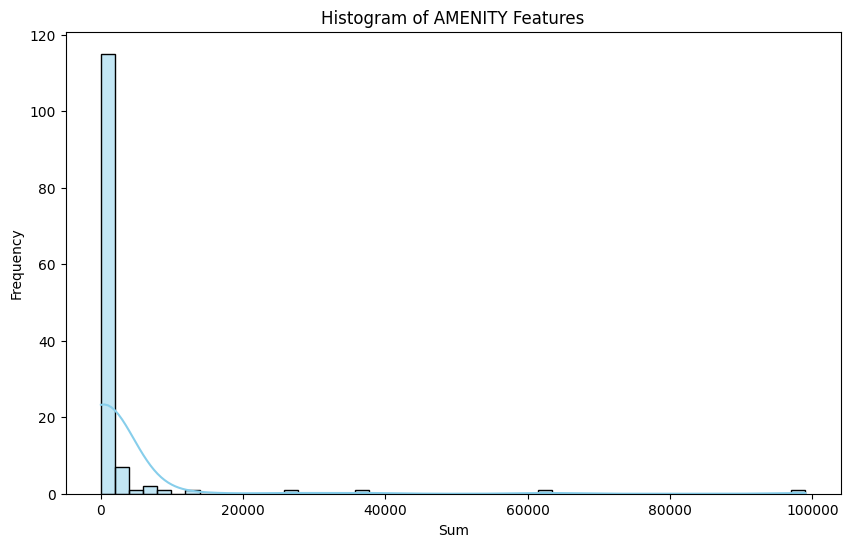

count      131.000000
mean      2375.671756
std      10924.036303
min          7.000000
25%         14.000000
50%        105.000000
75%        511.000000
max      99038.000000
dtype: float64


Most common features for AMENITY: 
 ['A_atm', 'A_bench', 'A_bicycle_', 'A_cafe', 'A_fast_foo', 'A_kinderga', 'A_parcel_l', 'A_parking', 'A_parking_', 'A_parkin_1', 'A_pharmacy', 'A_place_of', 'A_recyclin', 'A_restaura', 'A_school', 'A_shelter', 'A_universi', 'A_vending_', 'A_waste_ba', 'A_waste__1']


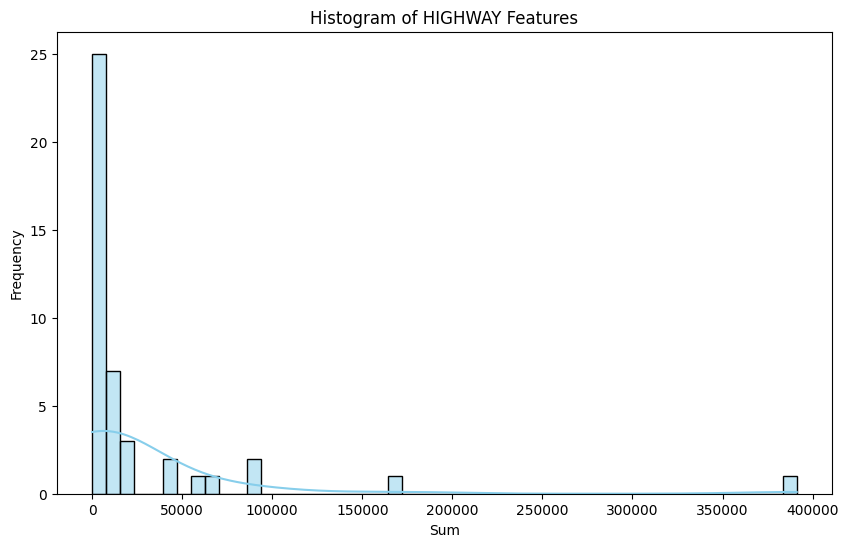

count        43.000000
mean      26049.116279
std       66130.637372
min           7.000000
25%         345.500000
50%        2124.000000
75%       15733.000000
max      391177.000000
dtype: float64


Most common features for HIGHWAY: 
 ['H_crossing', 'H_footway', 'H_path', 'H_resident', 'H_service', 'H_street_l', 'H_tertiary', 'H_track']


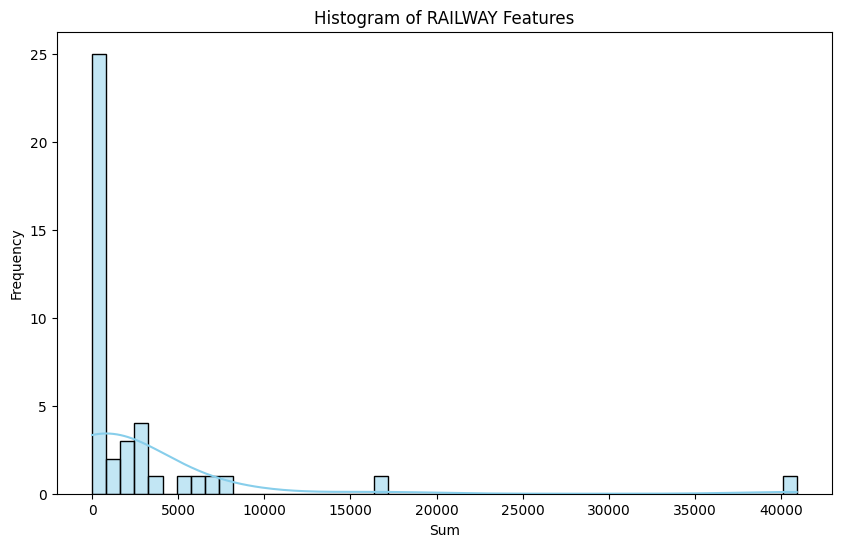

count       41.000000
mean      2654.878049
std       6875.431700
min          7.000000
25%         42.000000
50%        166.000000
75%       2464.000000
max      40907.000000
dtype: float64


Most common features for RAILWAY: 
 ['R_rail', 'R_switch', 'R_tram', 'R_tram_cro', 'R_tram_lev']
Found only one feature for feature group ROUTE


RO_piste    98
dtype: int64


All Most Common Features in the City:
A_atm
A_bench
A_bicycle_
A_cafe
A_fast_foo
A_kinderga
A_parcel_l
A_parking
A_parking_
A_parkin_1
A_pharmacy
A_place_of
A_recyclin
A_restaura
A_school
A_shelter
A_universi
A_vending_
A_waste_ba
A_waste__1
H_crossing
H_footway
H_path
H_resident
H_service
H_street_l
H_tertiary
H_track
R_rail
R_switch
R_tram
R_tram_cro
R_tram_lev


In [20]:
# resolution=8
# merged_gdf = merge_gdf(resolution)

all_most_common_features = []
feature_groups = [FeatureGoups.AMENITY, FeatureGoups.HIGHWAY, FeatureGoups.RAILWAY, FeatureGoups.ROUTE]
for feature_group in feature_groups:
    all_most_common_features.extend(analyze_features(merged_gdf, feature_group))
    
print(f"\nAll Most Common Features in the City:")
for feature in all_most_common_features:
    print(feature)

### SHAP

Analysis for Resolution = 8


100%|██████████| 922/922 [17:47<00:00,  1.16s/it]


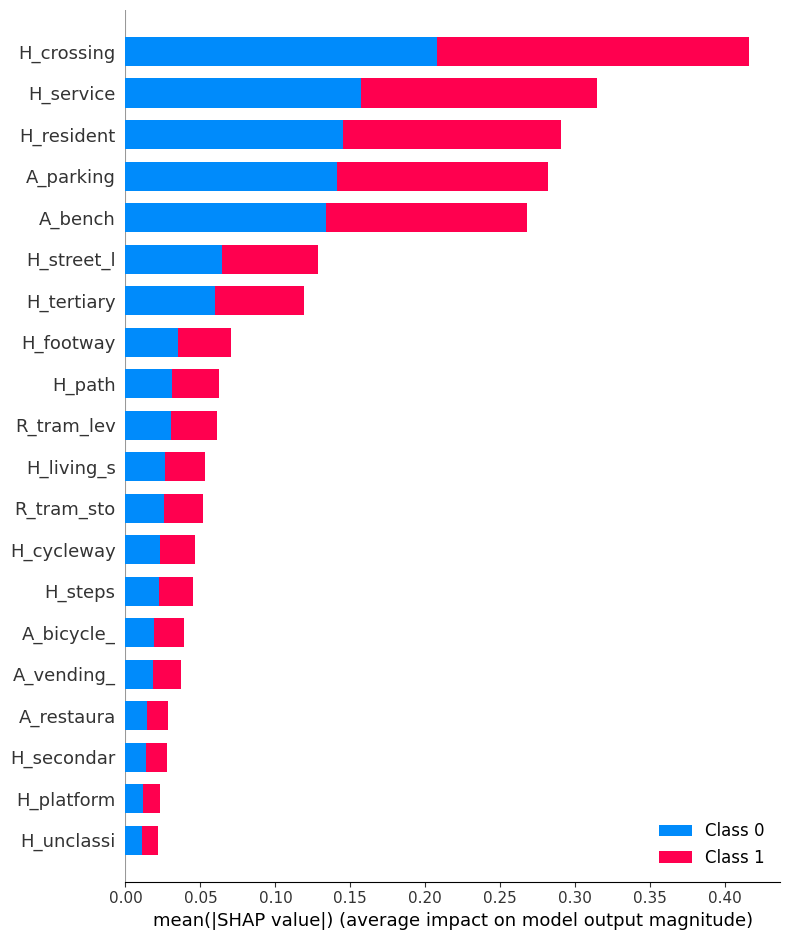

Analysis for Resolution = 9


100%|██████████| 5976/5976 [04:53<00:00, 20.39it/s]


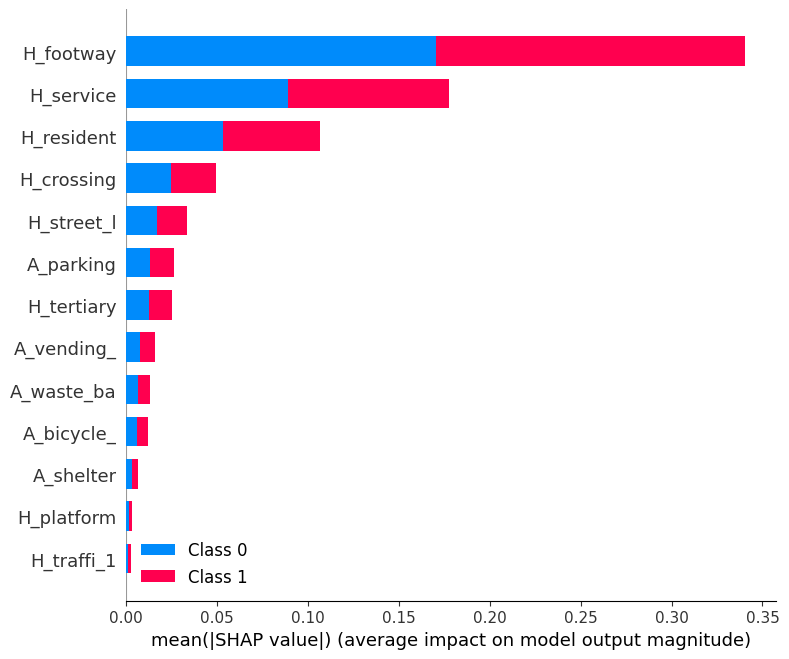

shap.plots.force is slow for many thousands of rows, try subsampling your data.


In [38]:
json_file_path = json_folder_path + f'all_high_corr_features_{city_name}.json'    
with open(json_file_path, 'r') as json_file:
    all_high_corr_features = json.load(json_file)
    
for resolution, highest_corr_features in all_high_corr_features.items():
    if highest_corr_features != []:
        merged_gdf = merge_gdf(resolution)
        shap_analysis(h3_resolution=resolution, merged_gdf=merged_gdf, selected_features=highest_corr_features, save_force_plot=True)
    

### Moran's I

In [ ]:
print("Local Moran's I Results:")
for resolution, results in local_moran_results.items():
    print(f"Resolution {resolution}: Moran's I = {results['moran_i']}, p_sim = {results['p_sim']}, q = {results['q']}")

Local Moran's I Results:
Resolution 8: Moran's I = [0.2824544  0.2824544  0.21737512 ... 0.21077618 0.18969434 0.04339257], p_sim = [0.001 0.001 0.001 ... 0.012 0.007 0.002], q = [3 3 3 ... 3 3 3]
Resolution 9: Moran's I = [0.0883899 0.0883899 0.0883899 ... 0.0883899 0.0883899 0.0883899], p_sim = [0.002 0.002 0.002 ... 0.004 0.004 0.004], q = [3 3 3 ... 3 3 3]
Resolution 10: Moran's I = [0.01833024 0.01833024 0.01833024 ... 0.01833024 0.01833024 0.01833024], p_sim = [0.001 0.001 0.001 ... 0.487 0.41  0.001], q = [3 3 3 ... 3 3 3]


In [ ]:
res = {}
for resolution, results in local_moran_results.items():
    res[resolution] = []
    for key, value in results.items():
        res[resolution].extend([np.mean(value), np.std(value), np.min(value), np.max(value)])

local_moran_metrics = list(local_moran_results.values())[0].keys()
id_names = [f'{key}_{stat}' for key in local_moran_metrics for stat in ['mean', 'std', 'min', 'max']]
        
df = pd.DataFrame(res, index=id_names)
df.columns = [f'resolution={resolution}' for resolution in df.columns]
display(df)

,resolution=8,resolution=9,resolution=10
moran_i_mean,0.621093,0.288214,0.185247
moran_i_std,2.147266,1.764179,2.383969
moran_i_min,-0.604564,-1.572244,-1.112252
moran_i_max,29.148883,55.413463,224.021940
p_sim_mean,0.045273,0.072602,0.017067
p_sim_std,0.104212,0.135616,0.077289
p_sim_min,0.001000,0.001000,0.001000
p_sim_max,0.476000,0.496000,0.500000
q_mean,2.528148,2.651604,2.852965
q_std,0.857162,0.680807,0.413714


#### Wnioski

**moran_i** <br>
 Dla rozdzielczości 8 (największe hexy) mamy silniejszy lokalny wzorzec korelacji niż dla rozdzielczości 9 i 10. Wyższe wartości wskazują na obszary, gdzie wartości są podobne do swoich sąsiadów, tworząc lokalne skupiska. <br>
 Odchylenie jest największe dla rozdzielczości 10, więc istnieje duża zmienność korelacji przestrzennej między heksagonami.
 Dla rozdzielczości 10, gdzie mamy największe wartości maksymalne, istnieją obszary o bardzo silnej lokalnej korelacji przestrzennej, co może oznaczać klastry podobnych wartości.

**p-wartość** <br>
 Im niższa wartość, tym silniejszy jest dowód na lokalną przestrzenną korelację. Dla wszystkich rozdzielczości średnie wartości p-sim są stosunkowo niskie, co wskazuje na istotność statystyczną lokalnego wzorca przestrzennej korelacji. <br>
 Dla największych wartości p_sim (bliskich 0.5) może oznaczać, że lokalny wskaźnik Morana nie jest istotny statystycznie w tych obszarach. Wartości te mogą pochodzić z obszarów o losowym rozkładzie, gdzie brak jest wyraźnych lokalnych wzorców. Niemniej jednak, wartości minimalne i wartość średnia sugerują, że dla większości obszarów lokalne wzorce korelacji są istotne.

**Q** <br>
 Wartości Q określają, do której kategorii kwadrantu należy dany obszar w analizie lokalnego Moran'a I. Średnie wartości dla wszystkich rozdzielczości wskazują na to, że większość obszarów należy do kwadrantów 1, 2 lub 3, co oznacza, że istnieją klastry obszarów o podobnych wartościach w sąsiedztwie.  <br>
 Kwadrant 4 oznacza obszary o wysokich wartościach otoczone przez obszary o niskich wartościach. Dla rozdzielczości 8 i 9 maksymalna wartość Q wynosi 4, co oznacza, że niektóre obszary są otoczone przez obszary o podobnych wartościach. Dla rozdzielczości 10 maksymalna wartość Q wynosi 3, co znaczy, że obszary o wyższych wartościach są bardziej izolowane lub mają bardziej zróżnicowane sąsiedztwo.